In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
sm2receptor = pd.read_csv('data/pairs.csv', sep=';')

In [4]:
sm2receptor['Mixture'].value_counts()

Mixture
mono              39230
sum of isomers    10920
mixture            1265
Name: count, dtype: int64

In [5]:
sm2receptor['Species'].value_counts()

Species
homo sapiens              40898
mus musculus              10242
pan troglodytes              55
pongo abelii                 50
bos taurus                   41
pan paniscus                 26
ovis aries                   25
canis lupus familiaris       25
vulpes vulpes                25
puma concolor                25
rattus norvegicus             3
Name: count, dtype: int64

In [6]:
sm2receptor['Mutation'].value_counts().head(20)

Mutation
D296N                                                                                                                            143
+1M                                                                                                                              124
Q293R                                                                                                                            122
M81V                                                                                                                              97
C149W                                                                                                                             67
L40Q                                                                                                                              64
V118M_Q234R                                                                                                                       64
F75S                                                        

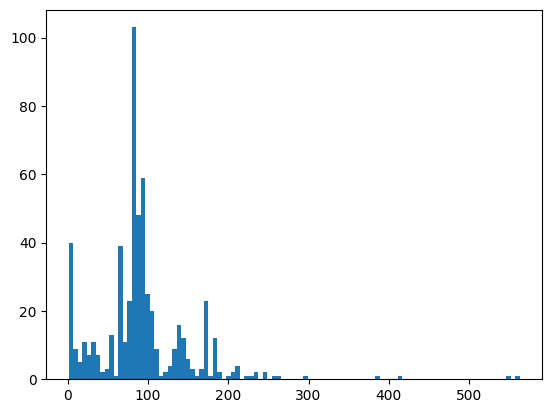

In [7]:
plt.hist(sm2receptor['Gene Name'].value_counts(), bins=100);

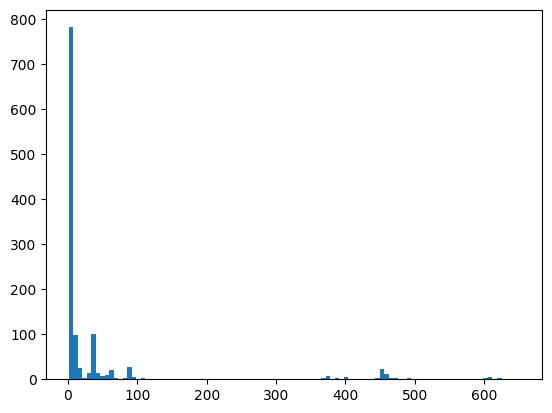

In [8]:
plt.hist(sm2receptor['Molecule Name'].value_counts(), bins=100);

In [9]:
sm2receptor['Responsive'].value_counts()

Responsive
0    48307
1     3108
Name: count, dtype: int64

In [10]:
sm2lang = pd.read_csv('data/Multi-Labelled_Smiles_Odors_dataset.csv')

In [11]:
sm2lang = sm2lang.rename({'nonStereoSMILES': 'SMILES'}, axis=1)

In [12]:
sm2lang['descriptors'].value_counts().head(20)

descriptors
odorless                                     199
fruity                                        42
waxy                                          24
fatty                                         24
sulfurous                                     20
woody                                         18
sweet                                         16
green                                         13
caramellic                                    13
spicy                                         12
fatty;oily                                    11
herbal                                        10
musk                                           9
fatty;waxy                                     9
floral                                         9
phenolic                                       8
gassy                                          8
vegetable;cognac;alcoholic;green;ethereal      8
fishy                                          8
balsamic                                       8
Name: co

In [13]:
sm2receptor.shape, sm2lang.shape

((51415, 14), (4983, 140))

In [14]:
sm2receptor.merge(sm2lang, on='SMILES', how='inner')['Responsive'].value_counts()

Responsive
0    10213
1      485
Name: count, dtype: int64

In [20]:
import torch
from protein_encoder import ProteinEncoder

In [16]:
prot_enc = ProteinEncoder(config_path='facebook/esm2_t6_8M_UR50D', out_dim=256)

/Users/ricomeinl/miniconda3/envs/biomlhack/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [21]:
device = torch.device('mps')

In [23]:
prot_enc.model = prot_enc.model.to(device)
prot_enc.out = prot_enc.out.to(device)

In [25]:
sm2receptor['UniProt ID'].nunique(), sm2receptor['Sequence'].nunique(), sm2receptor[['UniProt ID', 'Sequence']].nunique()

(589,
 1254,
 UniProt ID     589
 Sequence      1254
 dtype: int64)

In [26]:
uniprot2seq = sm2receptor[['UniProt ID', 'Sequence']].set_index('UniProt ID')['Sequence'].to_dict()

In [35]:
enc = prot_enc.tokenizer.encode(uniprot2seq['Q8NGN2'])

In [40]:
protein_inputs = prot_enc.tokenizer.batch_encode_plus(uniprot2seq['Q8NGN2'], return_tensors="pt", padding=True)
protein_inputs = {k: v.to(device) for k, v in protein_inputs.items()}
output, _ = prot_enc.forward(protein_inputs)

In [42]:
emb = prot_enc.get_repr(list(uniprot2seq.values())).numpy(force=True, verbose=True)

RuntimeError: MPS backend out of memory (MPS allocated: 60.15 GB, other allocations: 1.44 GB, max allowed: 61.20 GB). Tried to allocate 28.98 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).